<a href="https://colab.research.google.com/github/chandagrover/Machine-Learning/blob/master/SMILESVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget -c https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
!chmod +x Miniconda3-py37_4.8.3-Linux-x86_64.sh
!time bash ./Miniconda3-py37_4.8.3-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2020-09-08 19:07:12--  https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh [following]
--2020-09-08 19:07:12--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - \ | / - \ | / - \ | / - \ failed w

In [2]:
# General Imports
import os
import pandas as pd
import numpy as np
import sklearn
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
from matplotlib import pyplot as plt

In [3]:
smifile = "sample_data/AAAA.smi"
data = pd.read_csv(smifile, delimiter = " ", names = ["smiles","zinc_id"])
data["smiles"].head()

0                                     smiles
1                 Cn1cnc2c1c(=O)n(C)c(=O)n2C
2    O=C(O)[C@@H]1/C(=C/CO)O[C@@H]2CC(=O)N21
3                   Cn1c2nncnc2c(=O)n(C)c1=O
4                 Cn1cnc2c1c(=O)[nH]c(=O)n2C
Name: smiles, dtype: object

In [4]:
from sklearn.model_selection import train_test_split
smiles_train, smiles_test = train_test_split(data["smiles"], random_state=42)
print(smiles_train.shape)
print(smiles_test.shape)

(2844,)
(948,)


In [5]:
charset = set("".join(list(data.smiles))+"!E")
char_to_int = dict((c,i) for i,c in enumerate(charset))
int_to_char = dict((i,c) for i,c in enumerate(charset))
# embed = max([len(smile) for smile in data.smiles]) + 5
embed = max([len(smile) for smile in data.smiles])+2
print(char_to_int)
print(len(charset), embed)
print(embed)

{'i': 0, '(': 1, '5': 2, '@': 3, 'e': 4, 'c': 5, 'P': 6, '\\': 7, 'E': 8, '2': 9, 's': 10, '-': 11, '#': 12, 'H': 13, 'l': 14, 'B': 15, 'O': 16, 'N': 17, '1': 18, ')': 19, 'n': 20, 'S': 21, 'm': 22, 'C': 23, ']': 24, 'o': 25, '+': 26, '3': 27, '[': 28, 'F': 29, '4': 30, '!': 31, '=': 32, '6': 33, '/': 34}
35 58
58


In [6]:
print(type(smiles_train))
print(smiles_train.values[0])
print(len(smiles_train.values[0]))

<class 'pandas.core.series.Series'>
CNC1(C(N)=O)CCNCC1
18


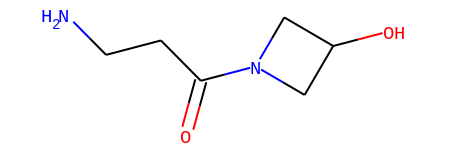

In [7]:
from rdkit.Chem.Draw import IPythonConsole
m = Chem.MolFromSmiles(smiles_train.values[100])
m

In [8]:
def vectorize(smiles):
        onehot_flatList=[[]]
        one_hot =  np.zeros((smiles.shape[0], embed , len(charset)),dtype=np.int8)
        print(one_hot.shape)
        for i,smile in enumerate(smiles):
            #encode the startchar
            one_hot[i,0,char_to_int["!"]] = 1
            #encode the rest of the chars
            for j,c in enumerate(smile):
                one_hot[i,j+1,char_to_int[c]] = 1
            #Encode endchar
            one_hot[i,len(smile)+1:,char_to_int["E"]] = 1
        #Return two, one for input and the other for output
        return one_hot[:,:,:]

X_train= vectorize(smiles_train.values)
X_test = vectorize(smiles_test.values)

(2844, 58, 35)
(948, 58, 35)


In [9]:
# Going back from vectorized form back to a readable string
str="".join([int_to_char[idx] for idx in np.argmax(X_train[0,:,:], axis=1)])
print(str)
print(len(str))

!CNC1(C(N)=O)CCNCC1EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
58


In [10]:
mol_size_x=X_train.shape[1]
mol_size_y=X_train.shape[2]
orig_dim = mol_size_x * mol_size_y
print(mol_size_x)
print(mol_size_y)
print(orig_dim)

58
35
2030


In [11]:
X_train = np.reshape(X_train, [-1, orig_dim])
X_test = np.reshape(X_test, [-1, orig_dim])
print(type(X_train))
print(X_train.shape[1])

<class 'numpy.ndarray'>
2030


In [12]:
# X_trainn=X_train.reshape(len(X_train), X_train.shape[1]*X_train.shape[2])
# X_testt=X_test.reshape(len(X_test), X_test.shape[1]*X_test.shape[2])

In [13]:
# Designing a Variaitonal AutoEncoder
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
# import numpy as np
# from matplotlib import pyplot as plt
# from keras.datasets import mnist
import os

In [14]:
# Network Parameters
input_shape=(orig_dim,)
intermediate_dim=512
batch_size=128
latent_dim=2
epochs=50

In [15]:
# Create a Variational AutoEncoder Model = Encoder + Decoder
inputs = Input(shape=input_shape, name='Encoder_input')
x = Dense(intermediate_dim,activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

In [16]:
print(inputs.shape)
print(type(inputs))
print(inputs[0])

print(x.shape)
print(type(x))
print(x[0])


(None, 2030)
<class 'tensorflow.python.framework.ops.Tensor'>
Tensor("strided_slice:0", shape=(2030,), dtype=float32)
(None, 512)
<class 'tensorflow.python.framework.ops.Tensor'>
Tensor("strided_slice_1:0", shape=(512,), dtype=float32)


In [17]:
# Sampling Method
def sampling(args):
    z_mean, z_log_var = args
    batch= K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normalshape=((batch, dim))
    print(batch)
    print(dim)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon  

In [18]:
def plot_results(models, data, batch_size=128, model_name='VAE_SMILE'):
    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)
    
    filename = os.path.join(model_name, "smilesvae_mean.png")
    z_mean,_,_ = encoder.predict(x_test, batch_size=batch_size)
    print(z_mean)
    
    plt.figure(figsize=(12,10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1])
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()


# models=(encoder, decoder)
# data=(X_test,X_test)

# plot_results(models, data, batch_size=batch_size, model_name='smilesvae_mlp')
    

    
    
    # filename = os.path.join(model_name, "digits with latent variable.png")
    # n=30
    # digit_size=28
    # figure = np.zeros((digit_size * n, digit_size * n))
    # grid_x = np.linspace(-4,4,n)
    # grid_y = np.linspace(-4,4,n)[::-1]
    
    # for i, yi in enumerate(grid_y):
    #     for j,xi in enumerate(grid_x):
    #         z_sample = np.array([[xi,yi]])
    #         x_decoded = decoder.predict(z_sample)
    #         digit = x_decoded[0].reshape(digit_size,digit_size)
    #         figure[i * digit_size: (i+1) * digit_size, j*digit_size:(j+1)*digit_size] =digit
    
    
    # plt.figure(figsize=(10,10))
    # start_range = digit_size // 2
    # end_range = (n-1) * digit_size + start_range + 1
    # pixel_range = np.arange(start_range, end_range, digit_size)
    # sample_range_x = np.round(grid_x, 1)
    # sample_range_y = np.round(grid_y, 1)
    # plt.xlabel("z[0]")
    # plt.ylabel("z[1]")
    # plt.imshow(figure, cmap='Greys_r')
    # plt.savefig(filename)
    # plt.show()

In [19]:
# Reparameterization Trick
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

Tensor("z/strided_slice:0", shape=(), dtype=int32)
2


In [20]:
# Initialize the Encoder Model
encoder = Model(inputs, [z_mean, z_log_var,z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Encoder_input (InputLayer)      [(None, 2030)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          1039872     Encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense[0][0]                      
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense[0][0]                      
____________________________________________________________________________________________

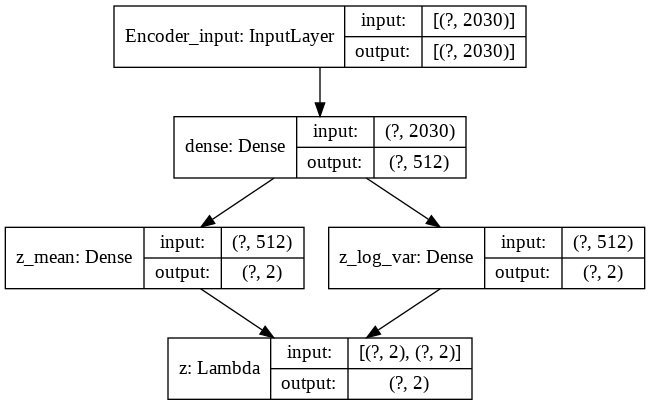

In [21]:
# Plot the Encoder Model
plot_model(encoder, to_file='smilesvae_encoder.png', show_shapes=True)

In [22]:
# Create the Decoder Model
latent_inputs = Input(shape=(latent_dim), name='z_smapling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(orig_dim, activation='sigmoid')(x)

In [23]:
# Initialize the Decoder Model
decoder = Model(latent_inputs, outputs, name='Decoder')
decoder.summary()

Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_smapling (InputLayer)      [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1536      
_________________________________________________________________
dense_2 (Dense)              (None, 2030)              1041390   
Total params: 1,042,926
Trainable params: 1,042,926
Non-trainable params: 0
_________________________________________________________________


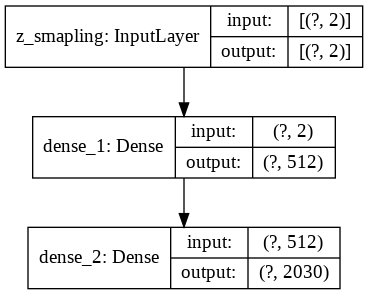

In [24]:
# Plot the Decoder Model
plot_model(decoder, to_file='smilesvae_decoder.png', show_shapes=True)

In [25]:
# Initialize the VAE
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='VAE')

Tensor("encoder/z/strided_slice:0", shape=(), dtype=int32)
2


Model: "VAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Encoder_input (InputLayer)      [(None, 2030)]       0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 2), (None, 2 1041924     Encoder_input[0][0]              
__________________________________________________________________________________________________
Decoder (Functional)            (None, 2030)         1042926     encoder[0][2]                    
__________________________________________________________________________________________________
tf_op_layer_Minimum (TensorFlow [(None, 2030)]       0           Decoder[0][0]                    
________________________________________________________________________________________________

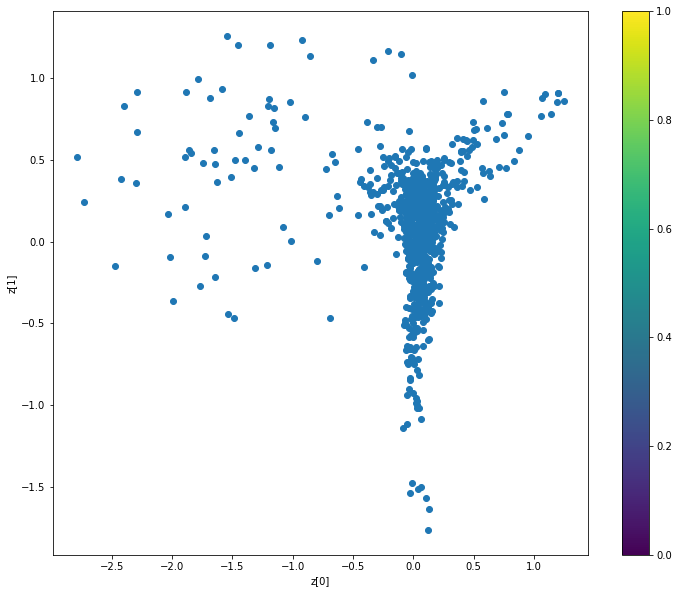

In [26]:
if __name__ == '__main__':
    models=(encoder, decoder)
    data=(X_test,X_test)

    reconstruction_loss = binary_crossentropy(inputs, outputs)
    reconstruction_loss = reconstruction_loss * orig_dim
    
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)    
    kl_loss = kl_loss * -0.5
    
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')
    vae.summary()
    plot_model(vae, to_file='smilesvae_enc_dec.png', show_shapes=True)
    
    
#     Train the AutoEncoder
    vae.fit(X_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, None))
    vae.save_weights('vae_mlp_smiles.h5')
    
    plot_results(models, data, batch_size=batch_size, model_name='smilesvae_mlp')
    